# Análise Preliminar para a implementação de ANOVA/MANOVA e Regressão Multipla

In [355]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import mutual_info_regression

import scipy.stats as stats

import warnings

warnings.filterwarnings("ignore")

# Formatação e Escolha dos Dados

- **Variáveis Escolhidas**: País, dançabilidade, energia, valência, tempo

In [356]:
df = pd.read_csv('../tabelas/musicas.csv')
variables = [
    'country', 'danceability', 'energy', 'valence', 'tempo'
]
df = df[variables]
df.head()

,country,danceability,energy,valence,tempo
0,BR,0.872,0.696,0.620,138.004
1,BR,0.790,0.849,0.800,118.074
2,BR,0.561,0.824,0.696,163.810
3,BR,0.891,0.436,0.962,133.964
4,BR,0.596,0.806,0.369,149.813


In [357]:
#  tema verde :)
cmap = plt.get_cmap("crest")
palette = [cmap(i) for i in np.linspace(0, 1, 6)]
sns.set_palette(palette)

## Normalização da Variável "Tempo" 

In [358]:
df['normalized_tempo'] = (df['tempo'] - df['tempo'].min()) / (df['tempo'].max() - df['tempo'].min())
df['normalized_tempo'] = np.ceil(df['normalized_tempo'] * 1000) / 1000
df.describe()

,danceability,energy,valence,tempo,normalized_tempo
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.654416,0.642552,0.551723,122.372258,0.393997
std,0.143469,0.167452,0.229785,27.368026,0.146216
min,0.220000,0.124000,0.047400,48.718000,0.000000
25%,0.545000,0.524000,0.370750,102.781000,0.289750
50%,0.663000,0.660500,0.549000,119.965000,0.381000
75%,0.758000,0.760000,0.739000,139.953750,0.488000
max,0.975000,0.972000,0.981000,235.907000,1.000000


# Dataframes dos Países


In [359]:
br_df = df.iloc[1:100]
au_df = df.iloc[101:200]
ca_df = df.iloc[201:300]
de_df = df.iloc[301:400]
gb_df = df.iloc[401:500]
in_df = df.iloc[501:600]
mx_df = df.iloc[601:700]
ng_df = df.iloc[701:800]
sg_df = df.iloc[801:900]
us_df = df.iloc[901:1000]
nz_df = df.iloc[1001:1100]
za_df = df.iloc[1101:1200]

# Análise Descritiva Básica

In [360]:
df.describe()

,danceability,energy,valence,tempo,normalized_tempo
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.654416,0.642552,0.551723,122.372258,0.393997
std,0.143469,0.167452,0.229785,27.368026,0.146216
min,0.220000,0.124000,0.047400,48.718000,0.000000
25%,0.545000,0.524000,0.370750,102.781000,0.289750
50%,0.663000,0.660500,0.549000,119.965000,0.381000
75%,0.758000,0.760000,0.739000,139.953750,0.488000
max,0.975000,0.972000,0.981000,235.907000,1.000000


# Distribuição das variáveis por país

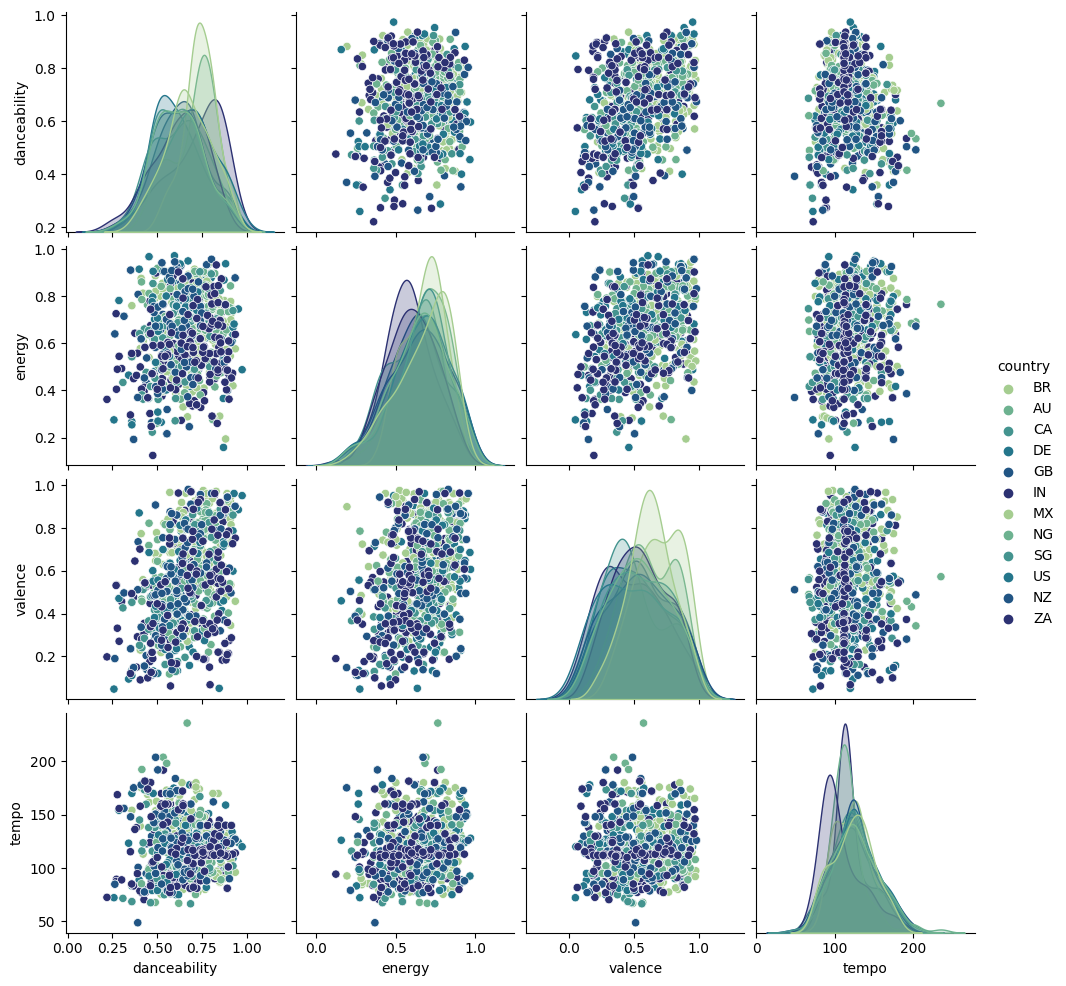

In [361]:
df1 = df.drop(columns=['normalized_tempo'])
sns.pairplot(df1, hue='country', palette=palette)
plt.show()

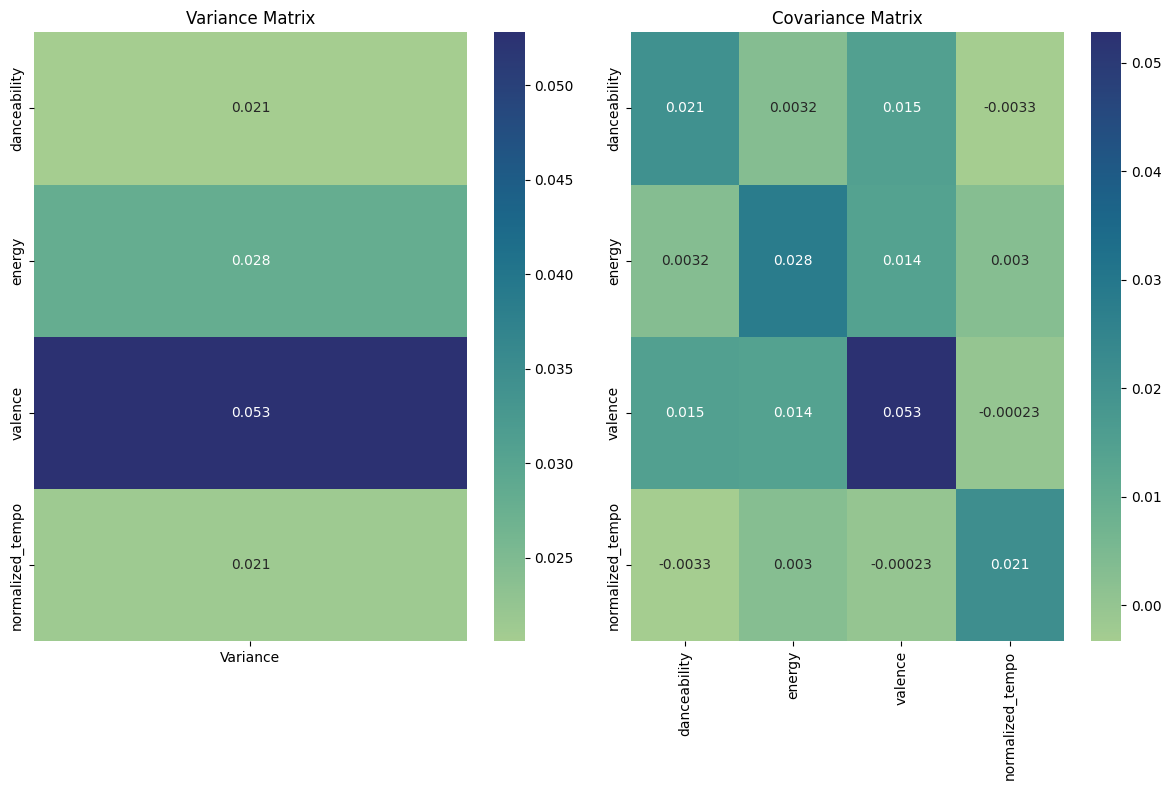

In [406]:
X = df.drop(columns=['country', 'tempo'])

variance_matrix = X.var().to_frame(name='Variance')
covariance_matrix = X.cov()

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.heatmap(variance_matrix, cmap=cmap,  annot=True, cbar=True)
plt.title('Variance Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(covariance_matrix, cmap=cmap , annot=True, cbar=True)
plt.title('Covariance Matrix')

plt.tight_layout()
plt.show()

# Testes de Normalidade

- **Conclusões:** As variáveis por país se demonstram normalizadas, mesmo que seus p-values variem bastante devido a outliers

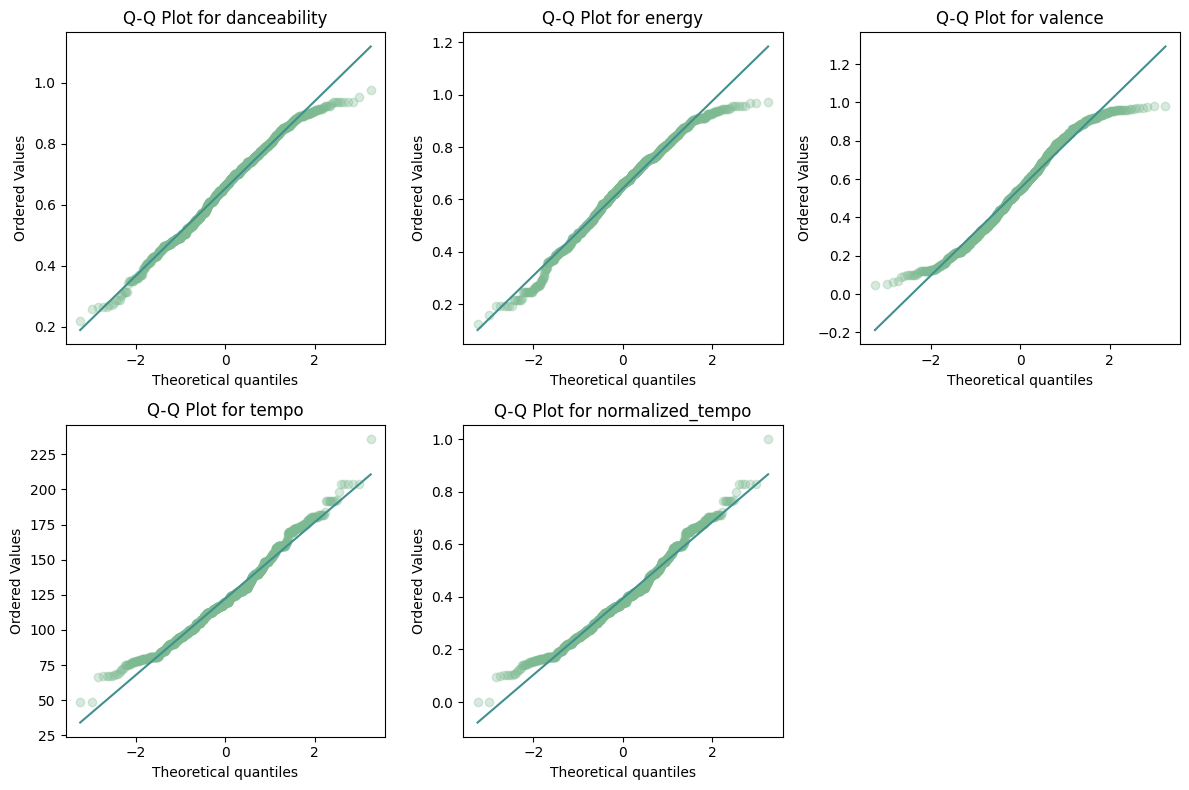

In [405]:
palette2 = sns.color_palette("crest", n_colors=6)

X = df.drop('country', axis=1)

plt.figure(figsize=(12, 8))

for i, column in enumerate(X.columns, 1):
    plt.subplot(2, 3, i)  
    stats.probplot(X[column], dist="norm", plot=plt)

    
    theoretical_line = plt.gca().get_lines()[0]
    theoretical_line.set_color(palette2[0])  
    theoretical_line.set_alpha(0.3)  

    
    sample_points = plt.gca().get_lines()[1]
    sample_points.set_color(palette2[2])  

    plt.title(f'Q-Q Plot for {column}')

plt.tight_layout()
plt.show()

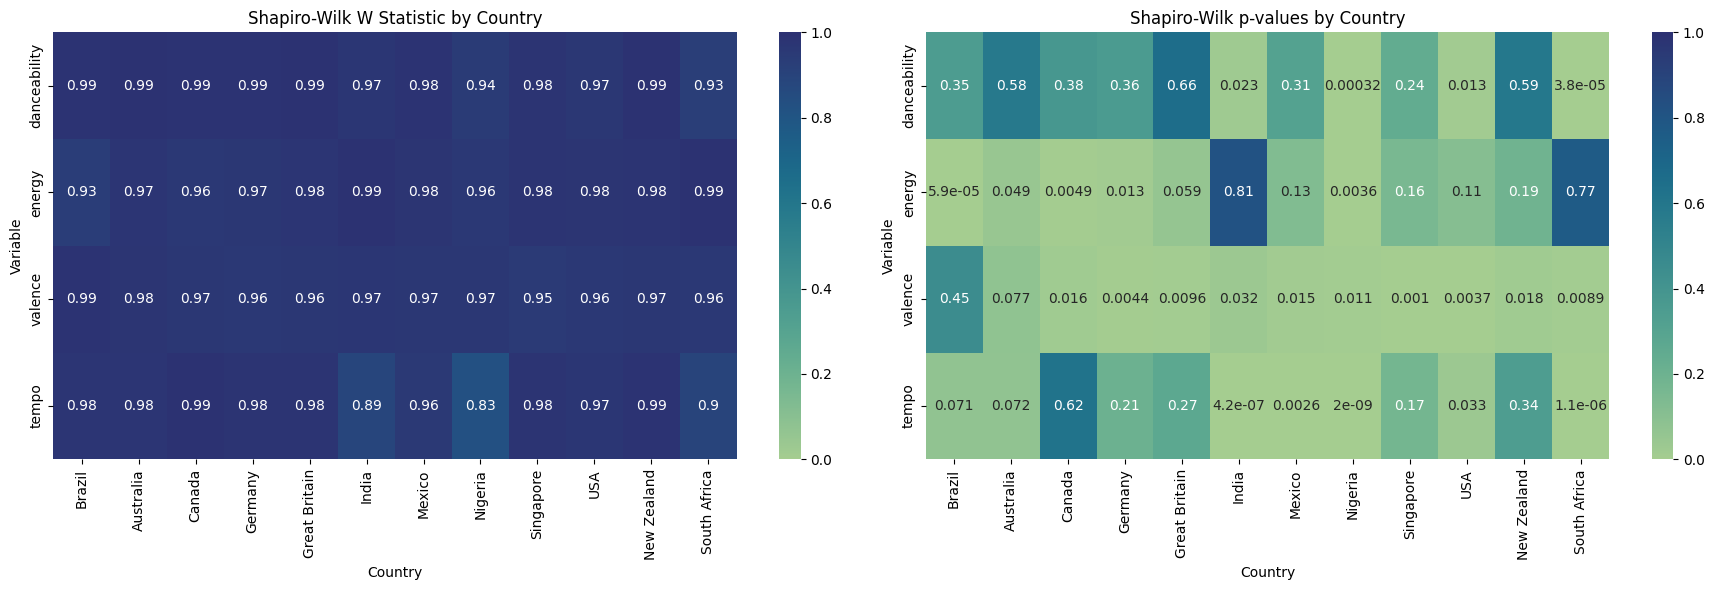

In [363]:
subsets = {
    'Brazil': br_df,
    'Australia': au_df,
    'Canada': ca_df,
    'Germany': de_df,
    'Great Britain': gb_df,
    'India': in_df,
    'Mexico': mx_df,
    'Nigeria': ng_df,
    'Singapore': sg_df,
    'USA': us_df,
    'New Zealand': nz_df,
    'South Africa': za_df
}

w_values_df = pd.DataFrame(columns=subsets.keys(), index=['danceability', 'energy', 'valence', 'tempo'])
p_values_df = pd.DataFrame(columns=subsets.keys(), index=['danceability', 'energy', 'valence', 'tempo'])

for country, subset in subsets.items():
    for column in ['danceability', 'energy', 'valence', 'tempo']:
        # Calculate Shapiro-Wilk test
        w_stat, p_value = stats.shapiro(subset[column])
        w_values_df.loc[column, country] = w_stat
        p_values_df.loc[column, country] = p_value

# Convert values to numeric
w_values_df = w_values_df.apply(pd.to_numeric, errors='coerce')
p_values_df = p_values_df.apply(pd.to_numeric, errors='coerce')


fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Create a heatmap for W statistics
sns.heatmap(w_values_df, ax=ax[0], cmap=cmap, annot=True, vmin=0, vmax=1, center=0.5)
ax[0].set_title('Shapiro-Wilk W Statistic by Country')
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Variable')

# Create a heatmap for p-values
sns.heatmap(p_values_df, ax=ax[1], cmap=cmap, annot=True, vmin=0, vmax=1, center=0.5)
ax[1].set_title('Shapiro-Wilk p-values by Country')
ax[1].set_xlabel('Country')
ax[1].set_ylabel('Variable')

plt.tight_layout()
plt.show()

# Distribuição das Variáveis para cada País

- **Destaque**: foi utilizado um plot KDE, basicamente um histograma plotado a partir de uma linha
- **Extra**: a variável tempo precisou ser normalizada para ajustar as observações

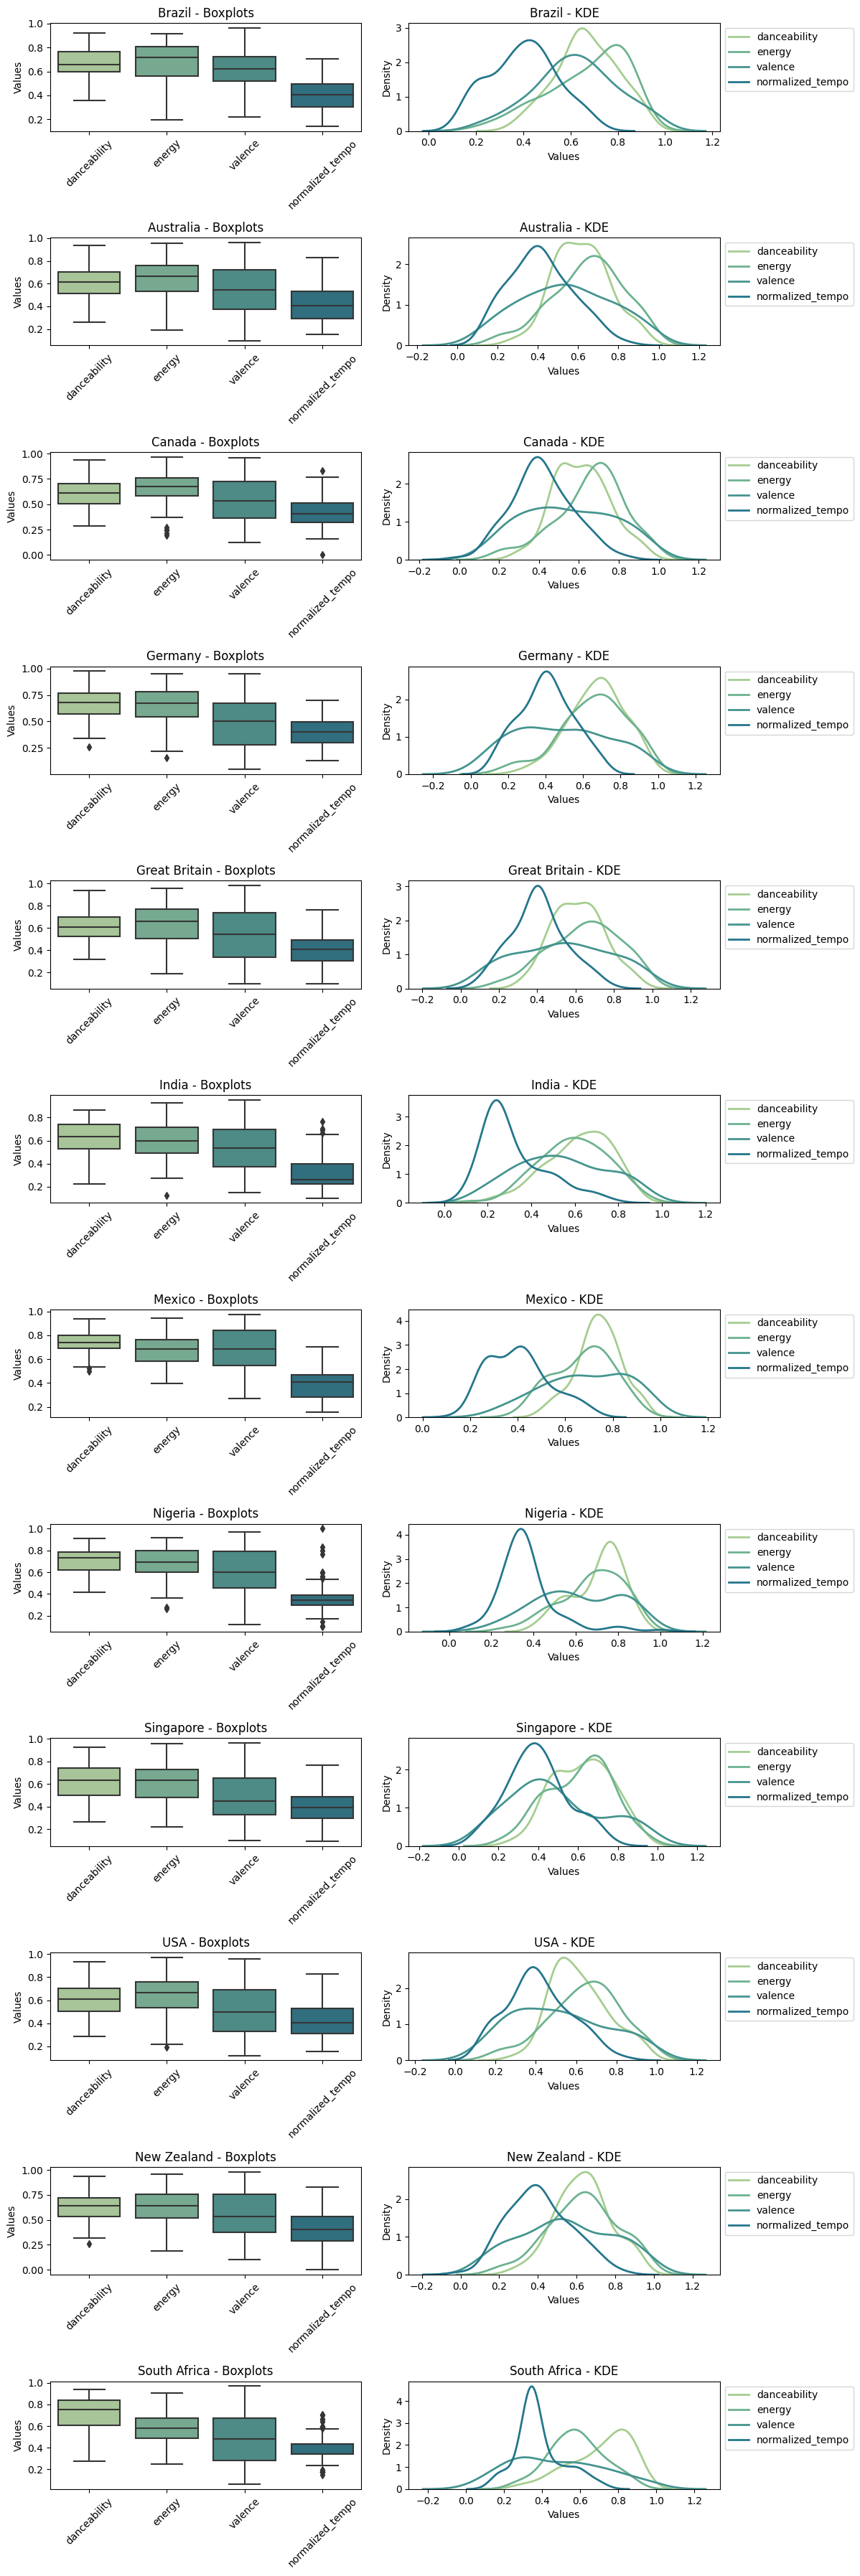

In [364]:
subsets = {
    'Brazil': br_df,
    'Australia': au_df,
    'Canada': ca_df,
    'Germany': de_df,
    'Great Britain': gb_df,
    'India': in_df,
    'Mexico': mx_df,
    'Nigeria': ng_df,
    'Singapore': sg_df,
    'USA': us_df,
    'New Zealand': nz_df,
    'South Africa': za_df
}

fig, axes = plt.subplots(nrows=len(subsets), ncols=2, figsize=(12, 3 * len(subsets)))
axes = axes.flatten()

variables = ['danceability', 'energy', 'valence', 'normalized_tempo']

for i, (country, subset) in enumerate(subsets.items()):
    # Boxplot for each country
    sns.boxplot(data=subset[variables], ax=axes[i * 2], palette=palette)
    axes[i * 2].set_title(f'{country} - Boxplots', fontsize=12)
    axes[i * 2].set_ylabel('Values')
    axes[i * 2].set_xticklabels(variables, rotation=45)

    # Overlapping KDE plots for each variable
    for variable in variables:
        sns.kdeplot(subset[variable], ax=axes[i * 2 + 1], label=variable, linewidth=2) 

    axes[i * 2 + 1].set_title(f'{country} - KDE', fontsize=12)
    axes[i * 2 + 1].set_xlabel('Values')
    axes[i * 2 + 1].set_ylabel('Density')
    axes[i * 2 + 1].legend()

    axes[i * 2 + 1].legend(loc='upper left', bbox_to_anchor=(1, 1))
    

plt.tight_layout()
plt.show()

# Correlações e Independências

- **Matriz de Correlação**: Leve correlação globalmente, grande correlação ente "danceability" e "valence", e entre "energy e "valence"
- **Informação Mútua**: Maior correlação entre x e x (a definir)
- **PCA**: Nenhuma distinção aparente

- **Conclusões**: Existem correlações entre as variáveis, porém elas não são muito fortes, mostrando que as variáveis são globalmente independentes

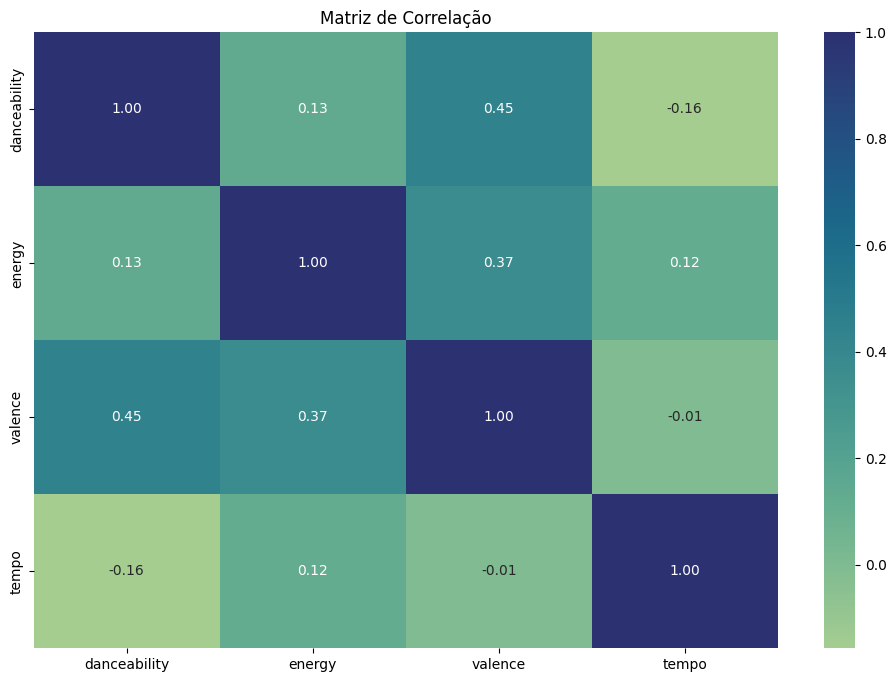

In [400]:
correlacoes = df.drop(columns=['country', 'normalized_tempo']).corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlacoes,cmap= "crest", annot=True, fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

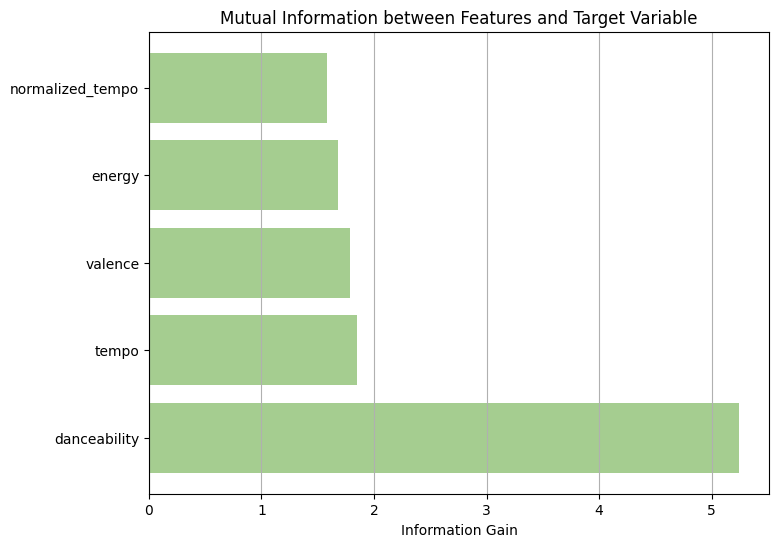

In [368]:
X = df.drop('country', axis=1)
y = df['danceability']  # Exemplo de variável alvo

mi_scores = mutual_info_regression(X, y)

mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})

mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(mi_df['Feature'], mi_df['Mutual Information'])
plt.xlabel('Information Gain')
plt.title('Mutual Information between Features and Target Variable')
plt.grid(axis='x')
plt.show()

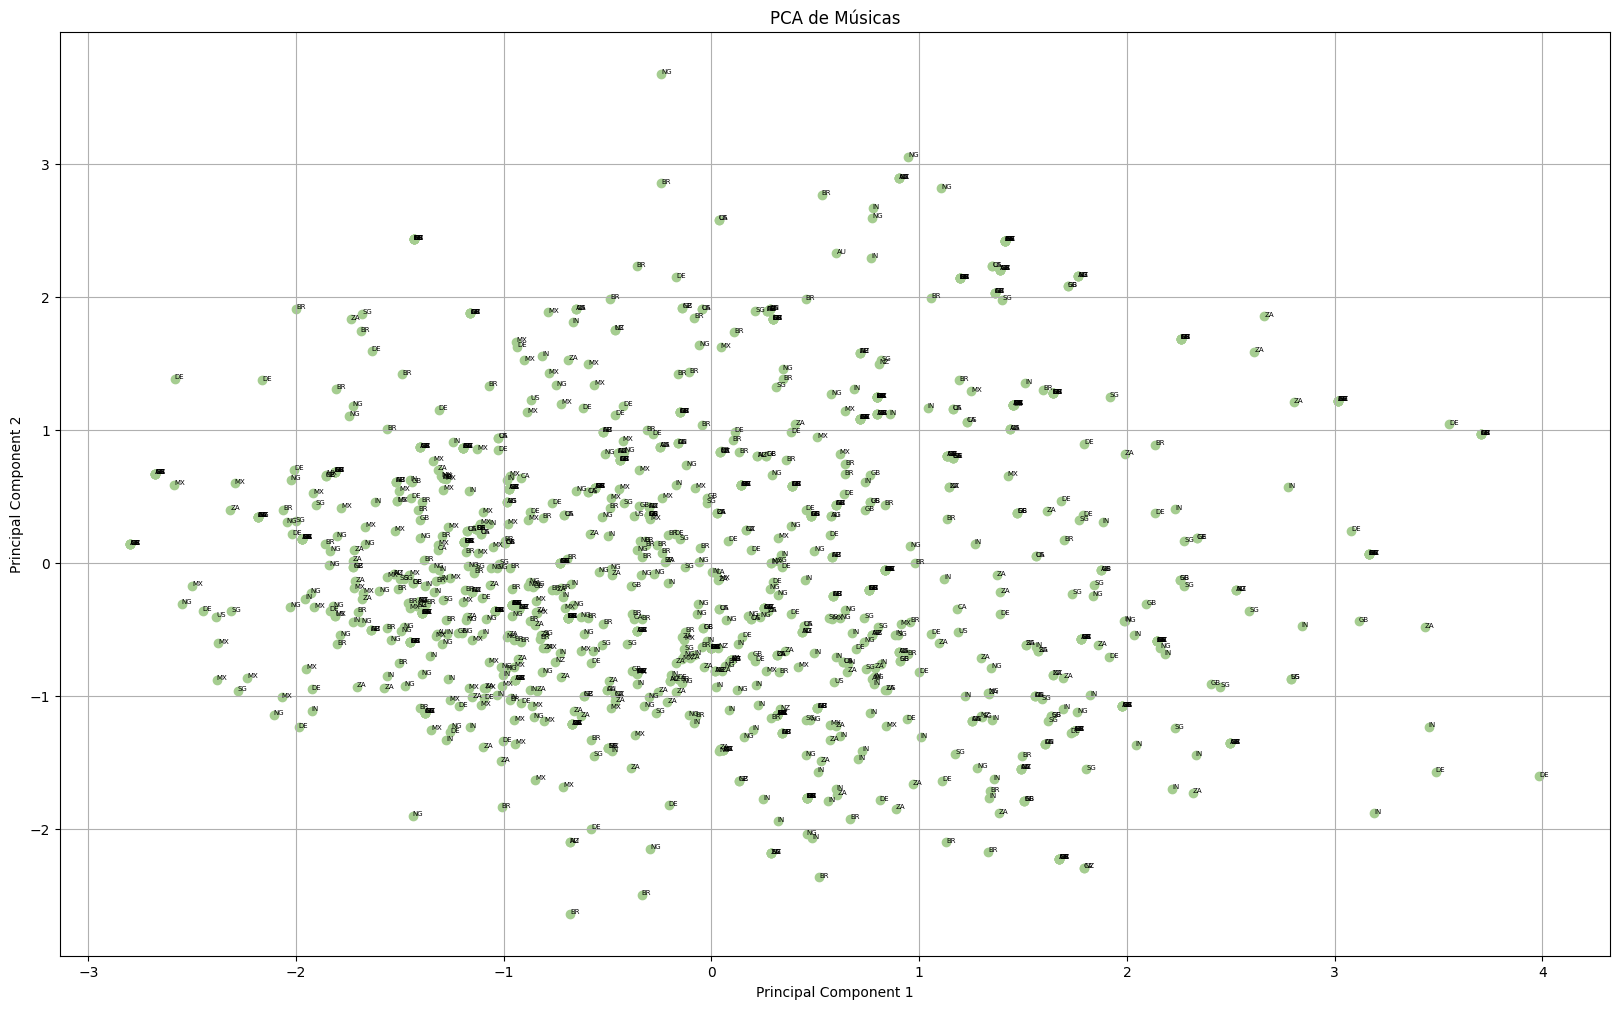

In [399]:
X = df.drop(columns=['country', 'normalized_tempo'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)  
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame for the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['country'] = df['country'].values

plt.figure(figsize=(20, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=1)
plt.title('PCA de Músicas')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

for i in range(len(pca_df)):
    plt.annotate(pca_df['country'].iloc[i], (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), fontsize=5)

plt.grid()
plt.show()

# Saída do Dataframe Normalizado 


In [370]:
dfo = df.copy()
dfo.drop(columns=['normalized_tempo'], inplace=True)
dfo['tempo'] = df['normalized_tempo']

dfo.head()

,country,danceability,energy,valence,tempo
0,BR,0.872,0.696,0.620,0.477
1,BR,0.790,0.849,0.800,0.371
2,BR,0.561,0.824,0.696,0.615
3,BR,0.891,0.436,0.962,0.456
4,BR,0.596,0.806,0.369,0.541


In [371]:
dfo.describe()

,danceability,energy,valence,tempo
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.654416,0.642552,0.551723,0.393997
std,0.143469,0.167452,0.229785,0.146216
min,0.220000,0.124000,0.047400,0.000000
25%,0.545000,0.524000,0.370750,0.289750
50%,0.663000,0.660500,0.549000,0.381000
75%,0.758000,0.760000,0.739000,0.488000
max,0.975000,0.972000,0.981000,1.000000


In [401]:
dfo.head()

,country,danceability,energy,valence,tempo
0,BR,0.872,0.696,0.620,0.477
1,BR,0.790,0.849,0.800,0.371
2,BR,0.561,0.824,0.696,0.615
3,BR,0.891,0.436,0.962,0.456
4,BR,0.596,0.806,0.369,0.541


In [372]:
output_path = '../tabelas/musicas_normalizadas.csv'

df = df.round(3)
dfo.to_csv(output_path, index=False)